In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [4]:
df = pd.read_csv("../data/covid.csv.gz")

In [6]:
df.tail()

,date,volume,query,geo
334459,2022-11-27,2455.963684,MacBook,PT
334460,2022-12-04,1975.439774,MacBook,PT
334461,2022-12-11,2620.525767,MacBook,PT
334462,2022-12-18,2300.950650,MacBook,PT
334463,2022-12-25,2478.486598,MacBook,PT


In [2]:
X_hat = np.load("../result/chatapp/lc=104/stl=26/rankupdate=1/ablation_s=0/ablation_d=0/outlier=1/log/X_hat.npy")

In [2]:
def load_tensor(path, time_key, facets, values=None, sampling_rate="D", start_date=None, end_date=None, scale="full"):
    df = pd.read_csv(path)
    tensor = df2tts(df, time_key=time_key, facets=facets, values=values, start_date=start_date, end_date=end_date)

    for key in facets:
        print(sorted(list(set(df[key]))))

    if scale=="full":
        tensor =  minmax_scale(tensor.reshape((-1, 1))).reshape(tensor.shape)

    return tensor

def df2tts(df, time_key, facets, values=None, sampling_rate="D", start_date=None, end_date=None):
    df[time_key] = pd.to_datetime(df[time_key])
    if start_date is not None: df = df[lambda x: x[time_key] >= pd.to_datetime(start_date)]
    if end_date is not None: df = df[lambda x: x[time_key] <= pd.to_datetime(end_date)]
    tmp = df.copy(deep=True)
    shape = tmp[facets].nunique().tolist()
    if values == None: values = 'count'; tmp[values] = 1
    tmp[time_key] = tmp[time_key].round(sampling_rate)
    print("Tensor:")
    print(tmp.nunique()[[time_key] + facets])

    grouped = tmp.groupby([time_key] + facets).sum()[[values]]
    grouped = grouped.unstack(fill_value=0).stack()
    grouped = grouped.pivot_table(index=time_key, columns=facets, values=values, fill_value=0)

    tts = grouped.values
    tts = np.reshape(tts, (-1, *shape))
    return tts

In [4]:
X = load_tensor("../data/chatapp.csv.gz", time_key="date", facets=["query", "geo"], values="volume", start_date="2010-01-01", end_date="2022-12-31")

Tensor:
date     678
query      8
geo       48
dtype: int64
['Apple Watch', 'Fitbit', 'Galaxy', 'Google Pixel', 'MacBook', 'Xperia', 'iPad', 'iPhone']
['AE', 'AR', 'AT', 'AU', 'BD', 'BE', 'BR', 'CA', 'CH', 'CL', 'CN', 'CO', 'CZ', 'DE', 'DK', 'EG', 'ES', 'FI', 'FR', 'GB', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IT', 'JP', 'KR', 'MX', 'MY', 'NG', 'NL', 'NO', 'PH', 'PK', 'PL', 'PT', 'RO', 'RU', 'SA', 'SE', 'TH', 'TR', 'TW', 'US', 'VN', 'ZA']


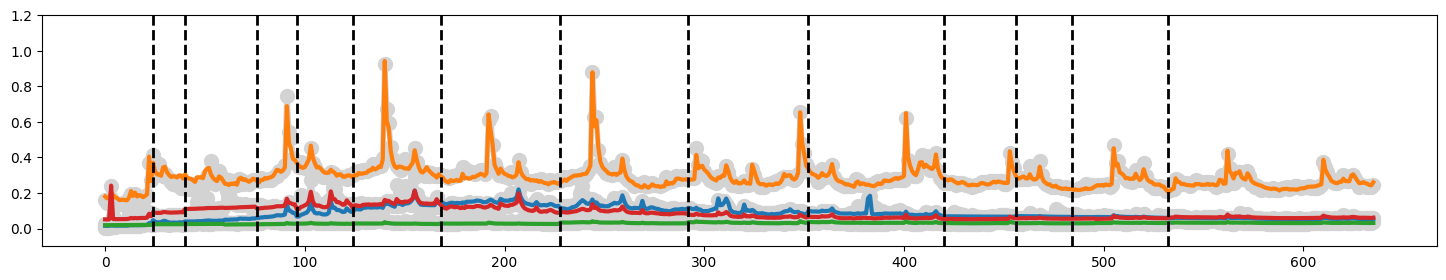

In [17]:
plt.figure(figsize=(18,3))
plt.plot(X[:636,[2,7,4,6],-3], linewidth=4, marker="o", markersize=10, color="lightgrey")
plt.plot(X_hat[:636,[2,7,4,6],-3], linewidth=3)
for x in [24,40,76,96,124,168,228,292,352,420,456,484,532]:
    plt.axvline(x=x, linestyle="dashed", ymin=0, ymax=1, color="black", linewidth=2)
plt.ylim([-0.1,1.2])
plt.show()

In [6]:
X_hat = np.concatenate([X_hat[:532,:,:], X_hat[535:,:,:]], axis=0)

In [20]:
X = load_tensor("../data/covid.csv.gz", time_key="date", facets=["key", "location_key"], values="value", start_date="2020-01-01", end_date="2022-09-30")
Xf_hat = np.load("../result/covid/lc=56/stl=7/rankupdate=1/ablation_s=0/ablation_d=0/outlier=1/log/Xf_hat.npy")

Tensor:
date            990
key               2
location_key     48
dtype: int64
['new_confirmed', 'new_deceased']
['AE', 'AR', 'AT', 'AU', 'BD', 'BE', 'BR', 'CA', 'CH', 'CL', 'CN', 'CO', 'CZ', 'DE', 'DK', 'EG', 'ES', 'FI', 'FR', 'GB', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IT', 'JP', 'KR', 'MX', 'MY', 'NG', 'NL', 'NO', 'PH', 'PK', 'PL', 'PT', 'RO', 'RU', 'SA', 'SE', 'TH', 'TR', 'TW', 'US', 'VN', 'ZA']


In [21]:
from tensorly.metrics.regression import RMSE
def MAE(pred, true):
    return np.mean(np.abs(pred - true))

In [23]:
Xf_hat[Xf_hat>1] = 1
RMSE(X[-604:], Xf_hat)

0.03726226807742643

In [22]:
RMSE(X[-604:], Xf_hat)

0.03978048668385673